In [1]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy
import math

In [2]:
age_class = ["<1", "1-4", "5-9", "10-14", "15-19", "20-29", "30+"]
#Select disease
d = "Measles"

#monthly data
data = pd.read_csv( d +'_data_processed.csv')
monthly_data = data.iloc[:,1:8]
monthly_data = monthly_data[age_class]

#I do not consider 2019
monthly_data = monthly_data.iloc[0:(data.shape[0]-12),:]

time_date = data["Time"][0:(data.shape[0]-12)]

if d== "Mumps":
    years_run = int(time_date[len(time_date)-1]) - int(time_date[0]) +1
    start_yr = int(time_date[0])
    end_yr = int(time_date[len(time_date)-1])
     
else:
    start_yr = int(time_date[0][0:4])
    end_yr = int(time_date[len(time_date)-1][0:4])
    years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1

print(start_yr)
print(end_yr)
print(years_run, "--> tmax")

1999
2018
20 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [3]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
if d == "Mumps":
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]
else:
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = np.asarray(list(reversed(Births_UK)))/1000 # Normalise to per capita
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018

Deaths_years = Deaths.iloc[:,np.where(Deaths.columns== str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns==str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#print(Pops_tot)

Pops_tot = np.asarray(Pops_tot)

##### Including real contact matrix from Polymod

- equally weighted one

In [4]:
Poly_7_new = pd.read_csv("Data/Poly_7.csv")
Poly_7_new = Poly_7_new.iloc[:,1:8]
Poly_7_new = Poly_7_new.iloc[np.hstack([6, np.arange(0,6)]),:]
C_poly = Poly_7_new.values

#### Vaccine coverage and Vaccinated IC

In [5]:
Cov_rate = pd.read_csv("Data//" +d +'_vaccine_coverage.csv')
V_ic = Cov_rate.iloc[0:7,1:2]
V_ic = V_ic.to_numpy().reshape((7,))/100
Cov_rate_years = Cov_rate.iloc[0:7,2:21]

# Issue: vaccination rate is up until 2016, now assume 2017-19 are the same?
Cov_rate_years["2017"] = Cov_rate_years["2018"]  = Cov_rate_years["2016"]

Cov_rate_years = Cov_rate_years.iloc[:,np.where(Cov_rate_years.columns== str(start_yr))[0][0]:np.where(Cov_rate_years.columns==str(end_yr))[0][0]+1]
Shift_cov_rate_years = Cov_rate_years.iloc[np.hstack([6, np.arange(0,6)]),:]

In [6]:
Shift_cov_rate_years_NEW = np.full(Shift_cov_rate_years.shape, 0, dtype = np.float32)
Shift_cov_rate_years_NEW[1,:] = Cov_rate_years.to_numpy()[1,:]
print(Shift_cov_rate_years_NEW)

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [74.45 74.1  74.3  74.6  74.3  73.5  73.1  73.95 77.4  81.55 83.8  85.8
  87.65 88.35 88.4  88.   87.6  87.4  87.4  87.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [7]:
from multiprocessing import Process, Array

def get_yearly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, n_years, dtype=np.int32)])

def get_monthly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, 12*n_years, dtype=np.int32)])
                       
def f_ssq(beta_vec):
    n_eval=120
    beta = np.eye(7)*np.maximum(beta_vec,0.0010)
    mdl = m.SIRVModel(para, lambda t: beta)
    
    ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)    
    
    if d == "Mumps":
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, pop_scale=pop_scale, atol =1e-6, rtol = 1e-3)
        new_inf = get_yearly_rates(out_YN, n_eval, years_run)
    else:
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, pop_scale=pop_scale, atol =1e-6, rtol = 1e-3)
        new_inf = get_monthly_rates(out_YN, n_eval, years_run)
    
    ssq = np.sum(np.sum((new_inf*((1/pop_scale)*1e5)-np.reshape(monthly_data[age_class].to_numpy()[0:-1], (7,-1)))**2))
    print("Loss: "+str(ssq)+" Beta: "+str(beta_vec))
    return ssq

def f_ssq_wrapper(beta_vec, ret):
    ret[0] = f_ssq(beta_vec)

def f_ssq_timeout(beta_vec):
    val = Array('d',1)
    p = Process(target=f_ssq_wrapper, args = (beta_vec,val,))
    p.start()
    p.join(30)
    if p.is_alive():
        print("Maximum computation time exceeded")
        p.terminate()
        p.join()
        return 1e100
    else:
        return val[0]

Each age group IC is weighted by their percetange at first year pop

In [8]:
def estimate_SIR_IC(mdl, age_struct, pop_scale, V_ic, eps_I = 1e-6, k=7):
    ###Start with a population where anyone who isnt vaccinated is susceptible 
    #(+eps_I level of infections))
    S_ic = (np.ones(k)-V_ic)*(1-eps_I)
    I_ic = (np.ones(k)-V_ic-S_ic)*[1,1,1,1,1,1,1]
    R_ic = (np.ones(k) - S_ic - I_ic - V_ic)
    
    #Normalise profile
    norm_ic = np.hstack([S_ic*age_struct_start,  
                    I_ic*age_struct_start,
                    R_ic*age_struct_start,
                    V_ic*age_struct_start])*pop_scale
    
    ### Run for a year
    out, t, out_YN = mdl.run(norm_ic, 
                             t_max = 1.0,
                             method="RK45",
                             eval_per_year=120,
                             pop_scale=pop_scale, atol=1e-4, rtol=1e-4)
    
    ### Note this only works for sensible betas and gammas 
    ###(i.e. assumes epidemic over in a year)
    level_estimate = out[:, -1]
    
    S_level = level_estimate[0:k]
    I_level = level_estimate[k:2*k]
    R_level = level_estimate[2*k:3*k]
    
    S_const = S_level/(S_level+I_level+R_level)
    I_const = I_level/(I_level+R_level)
    
    S_ic_est = (np.ones(k)-V_ic)*S_const
    I_ic_est = (np.ones(k)-V_ic-S_ic_est)*I_const
    R_ic_est = (np.ones(k)-V_ic-S_ic_est-I_ic_est)
    
    estimated_IC = np.hstack([S_ic_est*age_struct_start,
                              I_ic_est*age_struct_start,
                              R_ic_est*age_struct_start,
                              V_ic*age_struct_start])*1000
        
    return(estimated_IC)    

In [9]:
#Prepare Model Parameters
pop_scale = 1000.0 #Set scale to cases per 1000 
age_struct_start = np.asarray(Pops[str(start_yr)][0:7]/np.sum(Pops[str(start_yr)][0:7]))

para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B= lambda t: (Births_UK*pop_scale)[int(np.floor(t))],  #births rate per 1000
    V=lambda t: (Shift_cov_rate_years_NEW/100.0)[:, (int(np.floor(t))-1)],
    d=lambda t: Deaths_years.to_numpy()[:, int(np.floor(t))],  #death rate per capita
    gamma=(1/7*365.0)*np.ones([7]),
    C=C_poly*365,
    N= pop_scale
)


### Setting correct recovery rate

* Measles: recovery period of 7 - 10 days
* Mumps: 1 to 2 weeks
* Rubella: 3 days 

In [10]:
if d == "Measles":
    para.gamma = (1/8.5 *365.0)*np.ones([7]) #I compute the average
elif d == "Mumps":
    para.gamma = (1/10.5 *365.0)*np.ones([7])
elif d == "Rubella":
    para.gamma = (1/3 *365.0)*np.ones([7])

[ 48.16111111  48.16111111  70.67222222  58.93888889  51.30555556
  51.12777778 168.92777778]


Text(0.5, 1.0, 'Monthly infections per 100K')

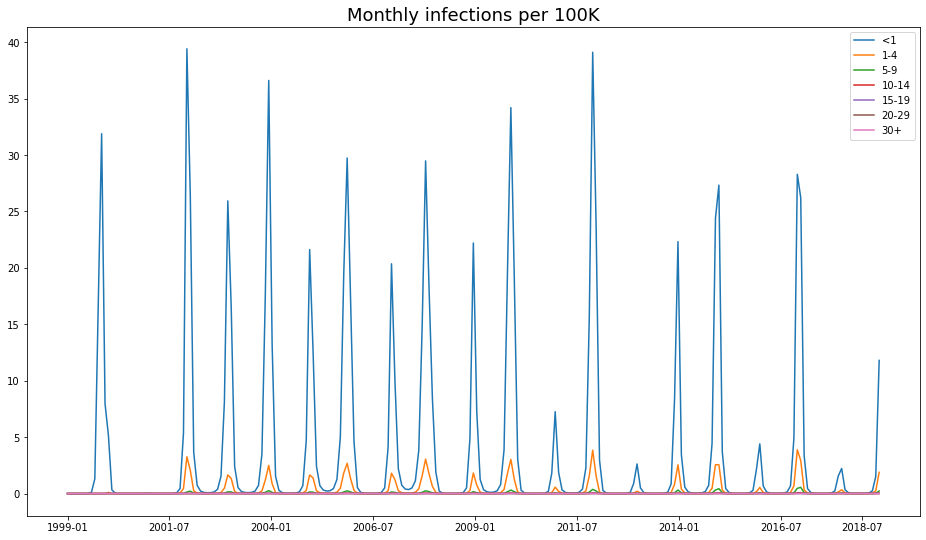

In [11]:
beta = np.eye(7)*np.ones(7)*10

print((beta@para.C/365)@np.ones(7))


mdl = m.SIRVModel(para, lambda t: beta)
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)

eval_year = 120
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.00001, method="RK45", eval_per_year=eval_year, pop_scale=pop_scale, 
                         atol=1e-6, rtol = 1e-4)
"""""
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t[0:len(t)], np.transpose(out[7+ii,0:len(t)]), label = age_class[ii])
plt.legend()
plt.title("Infected curve for all age groups (unnormalized)", fontsize = 18)
"""

plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)


Text(0.5, 1.0, 'Monthly infections per 100K')

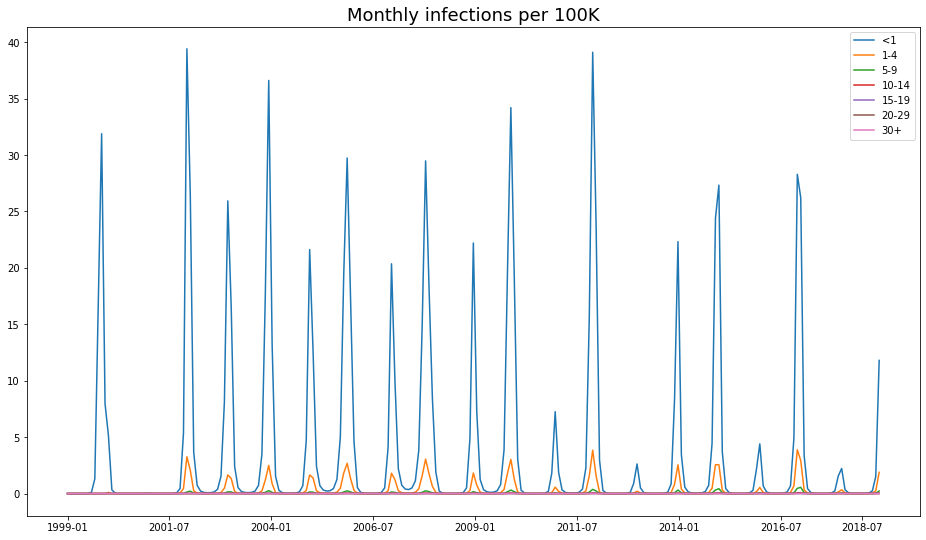

In [12]:
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)


NameError: name 'My_Time' is not defined

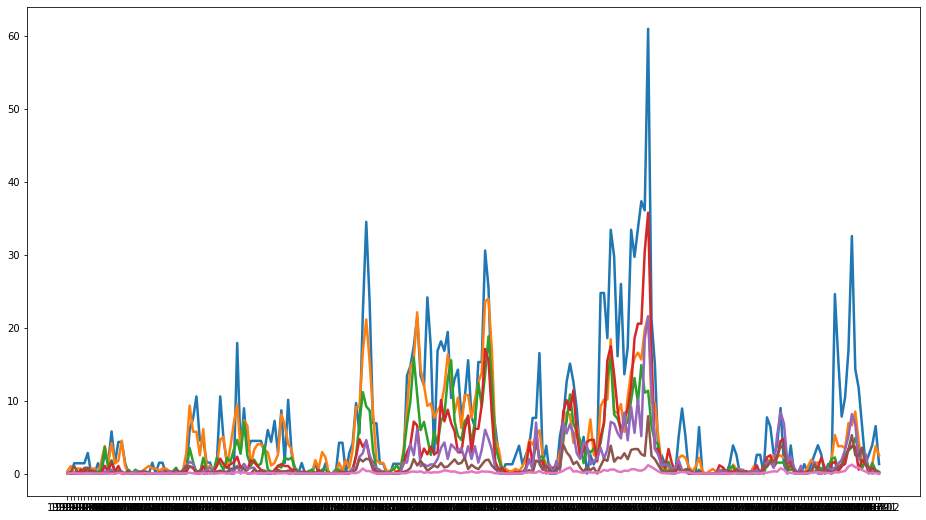

In [13]:
for d in ['Measles']:
#for d in ['Measles']:
    #option for dotted in Mumps
    if d == "Mumps":
        fig = plt.figure(figsize=(16,9))
        for cc in age_class:
            plt.plot(time_date, monthly_data[cc], "-o", markersize = 7, lw = 2.5, label= cc)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
    else:
        fig = plt.figure(figsize=(16,9))
        for cc in age_class:
            plt.plot(time_date, monthly_data[cc], lw = 2.5, label= cc)
        step_loc = math.floor(len(My_Time)/8)
        locs = np.arange(0, 9) * step_loc

        plt.yticks(fontsize = 18)
        #plt.xticks(locs, My_Time.loc[locs][0], fontsize = 18)
            
    plt.xlabel("Time", fontsize=18)
    plt.legend(shadow= True, fontsize = 19)
    plt.title(d+" Cases Per 100k", fontsize = 20)
    #svg better for Poster
    
    #plt.savefig(d+"Plot.svg")
    #plt.figure(figsize=(16,9))
    for ii in range(7):
        plt.plot(time_date[0:len(time_date)-1], 
                 (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])
    plt.legend()
    #plt.title("Monthly infections per 100K", fontsize = 18)


## Plotting the scaled infected by normalising pop

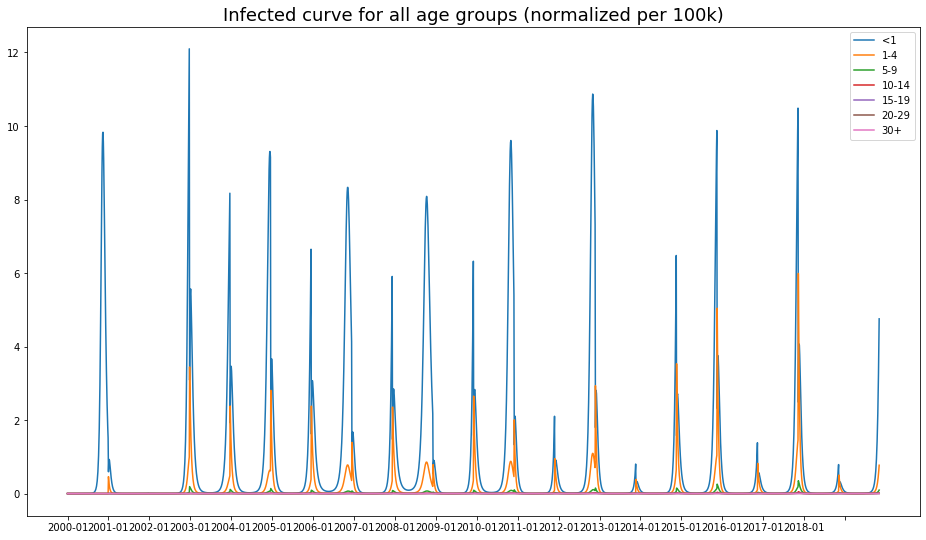

In [14]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    tot = np.sum(out[np.array([0,7,14,21])+ii,], axis=0)
    plt.plot(t[0:len(t)], (np.transpose(out[7+ii,]) / tot)[0:len(t)]*100, label = age_class[ii])
plt.legend()
if d == "Mumps":
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date)
else:
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date[np.arange(1, years_run)*12])

plt.title("Infected curve for all age groups (normalized per 100k)", fontsize = 18)

if d == "Mumps":
    plt.savefig("Inf_sim_"+d+"_noOpt.svg")

In [17]:
#fit_measles = scipy.optimize.fmin(f_ssq_timeout, x0 = np.array([0.0025,  0.25185257,  0.8639866 ,  0.74971919,  0.7785915 ,
#        1.57351055,  0.51410717]), xtol=1e-4
#                                  ,maxiter = 2000, maxfun = 2000, full_output=1)

fit_measles = scipy.optimize.fmin(f_ssq_timeout, x0 = np.array([15,15,15,15,15,15,15]), xtol=1e-3,maxiter = 2000, maxfun = 2000, full_output=1)

Loss: 113752.49564042425 Beta: [15. 15. 15. 15. 15. 15. 15.]
Loss: 117525.90187466252 Beta: [15.75 15.   15.   15.   15.   15.   15.  ]
Loss: 113232.54348761323 Beta: [15.   15.75 15.   15.   15.   15.   15.  ]
Loss: 113765.1042621289 Beta: [15.   15.   15.75 15.   15.   15.   15.  ]
Loss: 113752.41910142847 Beta: [15.   15.   15.   15.75 15.   15.   15.  ]
Loss: 113752.36861388534 Beta: [15.   15.   15.   15.   15.75 15.   15.  ]
Loss: 113752.5299534602 Beta: [15.   15.   15.   15.   15.   15.75 15.  ]
Loss: 113752.63039333055 Beta: [15.   15.   15.   15.   15.   15.   15.75]
Loss: 112834.0896958398 Beta: [14.25       15.21428571 15.21428571 15.21428571 15.21428571 15.21428571
 15.21428571]
Loss: 110131.77689699925 Beta: [13.5        15.32142857 15.32142857 15.32142857 15.32142857 15.32142857
 15.32142857]
Loss: 112930.8618591676 Beta: [14.57142857 15.30612245 14.34183673 15.30612245 15.30612245 15.30612245
 15.30612245]
Loss: 112759.1809619275 Beta: [14.44897959 15.39358601 14.903790

 16.71612466]
Loss: 57302.72232119294 Beta: [ 5.4511976  19.56373146 15.41831114 16.11549538 14.64032036 15.5705884
 16.76476154]
Maximum computation time exceeded
Maximum computation time exceeded
Loss: 57961.23641757533 Beta: [ 5.54964941 19.48198494 15.40618047 16.10038843 14.67061811 15.70501748
 16.63211884]
Maximum computation time exceeded
Loss: 57847.34825161366 Beta: [ 5.52606893 19.49126479 15.43257268 16.08453689 14.66150981 15.66981964
 16.70147509]
Maximum computation time exceeded
Loss: 57814.85599398381 Beta: [ 5.53106257 19.46770124 15.45775681 16.09711686 14.65458851 15.61566781
 16.76824476]
Maximum computation time exceeded
Loss: 57867.35572424087 Beta: [ 5.53241856 19.48575447 15.45283539 16.07226354 14.63365309 15.64946675
 16.74185227]
Loss: 57591.470754536036 Beta: [ 5.49726376 19.34726858 15.48486695 16.29622185 14.46709448 15.82572017
 16.49889669]
Maximum computation time exceeded
Loss: 57879.490372293614 Beta: [ 5.51174886 19.47797454 15.45818985 16.09758894 

 16.76355779]
Loss: 57282.93652571079 Beta: [ 5.45102568 19.56139356 15.41967212 16.0800942  14.65872803 15.60340194
 16.76118957]
Loss: 57281.780802780806 Beta: [ 5.45010526 19.56272033 15.41871217 16.0763148  14.66138422 15.60447719
 16.76165227]
Loss: 57283.685563548854 Beta: [ 5.45090445 19.56285737 15.4171173  16.07263943 14.66350396 15.6043658
 16.76150735]
Loss: 57281.658468333495 Beta: [ 5.44876503 19.56422254 15.41812386 16.07313062 14.66377653 15.60576878
 16.76224039]
Loss: 57280.83476356932 Beta: [ 5.44696697 19.56731523 15.41589622 16.07878777 14.66225649 15.59658667
 16.76425355]
Loss: 57281.02061314588 Beta: [ 5.44481403 19.57041821 15.41417706 16.0839437  14.66097601 15.58878854
 16.76623308]
Loss: 57280.53460384054 Beta: [ 5.44585726 19.5715961  15.414016   16.07359862 14.66867096 15.60062229
 16.76606361]
Maximum computation time exceeded
Loss: 57281.747295150104 Beta: [ 5.44566288 19.57085379 15.41437598 16.07628984 14.66647943 15.59976156
 16.76528421]
Loss: 57282.0

Maximum computation time exceeded
Loss: 57271.344585147905 Beta: [ 5.44837433 19.5359965  15.44032932 16.16501941 14.5956238  15.54045686
 16.76362123]
Loss: 57266.36370950378 Beta: [ 5.450493   19.51532752 15.45580295 16.21307277 14.55600239 15.50836243
 16.76218756]
Maximum computation time exceeded
Maximum computation time exceeded
Loss: 57269.90342031337 Beta: [ 5.44848686 19.53213055 15.44339458 16.17624118 14.58707392 15.53257213
 16.76376701]
Maximum computation time exceeded
Loss: 57269.732645427124 Beta: [ 5.44818586 19.53320216 15.44286235 16.17600116 14.58798799 15.53210634
 16.7643377 ]
Maximum computation time exceeded
Loss: 57269.51547058683 Beta: [ 5.44826857 19.53136044 15.44430396 16.17896772 14.58545416 15.53128294
 16.76397018]
Maximum computation time exceeded
Loss: 57269.287757349 Beta: [ 5.44860364 19.53034519 15.44489182 16.18049628 14.58388287 15.53014026
 16.76382656]
Maximum computation time exceeded
Loss: 57268.96844442545 Beta: [ 5.44862835 19.52917775 15.44

 16.75093333]
Loss: 57261.02572090069 Beta: [ 5.46564814 19.43098093 15.53316014 16.27478469 14.48333163 15.53320832
 16.74752599]
Loss: 57260.29371685763 Beta: [ 5.46372268 19.4406152  15.52556507 16.26412624 14.49468976 15.53594231
 16.74954504]
Loss: 57259.853283819306 Beta: [ 5.46750865 19.41872761 15.54669567 16.27676274 14.47853724 15.54715056
 16.74603944]
Loss: 57259.595271303915 Beta: [ 5.46405844 19.43679404 15.52889267 16.27110419 14.48878075 15.53259232
 16.7493525 ]
Loss: 57258.6408741372 Beta: [ 5.46688086 19.41880573 15.5459376  16.28573115 14.47275996 15.53708672
 16.74684429]
Loss: 57260.32464442169 Beta: [ 5.46741561 19.41883419 15.54510426 16.28425647 14.47320534 15.53790445
 16.74598135]
Loss: 57258.570425850296 Beta: [ 5.46442996 19.43211449 15.53491535 16.27107686 14.48765943 15.53843039
 16.74952878]
Loss: 57257.94048976807 Beta: [ 5.46556054 19.42217524 15.54590467 16.27603894 14.48143225 15.54490091
 16.74905083]
Loss: 57259.48963081595 Beta: [ 5.47054036 19.39

 16.73786949]
Loss: 57347.38826184055 Beta: [ 5.48211756 19.28495531 15.6897938  16.37046288 14.38028618 15.62407666
 16.7362211 ]
Loss: 57250.24578025534 Beta: [ 5.4800916  19.30510919 15.6674591  16.35836187 14.39293609 15.60728665
 16.73775761]
Loss: 57249.05538509572 Beta: [ 5.48046553 19.28990278 15.68638025 16.3686612  14.38429878 15.62301598
 16.73805945]
Loss: 57248.83564204314 Beta: [ 5.48133203 19.28693514 15.6886508  16.36986787 14.38198967 15.62398208
 16.73711422]
Loss: 57248.19263501983 Beta: [ 5.48195224 19.27784812 15.69924665 16.37562087 14.37651646 15.6323298
 16.73679252]
Loss: 57248.4298569172 Beta: [ 5.48033094 19.28664668 15.69129851 16.3691127  14.38445532 15.63104084
 16.73822886]
Loss: 57247.90907215179 Beta: [ 5.48015179 19.28737186 15.69049824 16.36993275 14.38449743 15.6306549
 16.73822611]
Loss: 57246.830556593675 Beta: [ 5.47962202 19.28310525 15.69711155 16.37312262 14.38340156 15.6395204
 16.73882748]
Loss: 57247.19938102455 Beta: [ 5.47902871 19.2955195

 16.76327719]
Maximum computation time exceeded
Loss: 57191.51350319783 Beta: [ 5.46217606 19.02751576 16.0641697  16.55101622 14.29018811 16.07195651
 16.76343043]
Maximum computation time exceeded
Loss: 57191.38970469806 Beta: [ 5.46209201 19.02730424 16.06466231 16.55100345 14.29039804 16.07302939
 16.76351767]
Maximum computation time exceeded
Loss: 57191.23992157528 Beta: [ 5.46223518 19.02247567 16.07066918 16.55399411 14.28785957 16.07850898
 16.76354089]
Loss: 57190.230608796664 Beta: [ 5.46173443 19.01714733 16.0785965  16.55779588 14.2861209  16.08816233
 16.76421033]
Maximum computation time exceeded
Maximum computation time exceeded
Loss: 57191.03552494837 Beta: [ 5.46199809 19.0240924  16.06901801 16.55318992 14.28897076 16.07762533
 16.7637185 ]
Maximum computation time exceeded
Loss: 57190.9502843323 Beta: [ 5.46205274 19.02179359 16.0719035  16.55462781 14.2877809  16.08030201
 16.7637428 ]
Maximum computation time exceeded
Loss: 57190.901735641106 Beta: [ 5.46183819 19

Process Process-1685:
Traceback (most recent call last):
  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-f1719827a51a>", line 28, in f_ssq_wrapper
    ret[0] = f_ssq(beta_vec)
  File "<ipython-input-7-f1719827a51a>", line 20, in f_ssq
    out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, pop_scale=pop_scale, atol =1e-6, rtol = 1e-3)
  File "/mnt/c/Users/david/GitHub/EpiRSG2020/model/model.py", line 171, in run
    sol_1_year = solve_ivp(self.__dt__, t_span = t_span, y0 = Y0, method = method, t_eval = np.linspace(t0, tend, num=eval_per_year), atol=atol, rtol=rtol)
  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver

KeyboardInterrupt: 

  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py", line 145, in _step_impl
    y_new, f_new = rk_step(self.fun, t, y, self.f, h, self.A,
  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py", line 65, in rk_step
    K[s] = fun(t + c * h, y + dy)
  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 139, in fun
    return self.fun_single(t, y)
  File "/home/dhelekal/anaconda3/envs/nb/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 21, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
  File "/mnt/c/Users/david/GitHub/EpiRSG2020/model/model.py", line 101, in __dt__
    di = s*(beta(t)@C@i)/N - (d(t)+gamma)@i
  File "/mnt/c/Users/david/GitHub/EpiRSG2020/model/model.py

In [ ]:
beta = np.eye(7)*np.maximum(fit_measles[0],0.0025)

mdl = m.SIRVModel(para, lambda t: beta)
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)

eval_year = 120
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.00001, method="RK45", eval_per_year=eval_year, pop_scale=pop_scale, 
                         atol=1e-6, rtol = 1e-4)

plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)

In [ ]:
fit_measles[0]

##### 